In [41]:
#if not installed uncomment and run the below.
#pip install yfinance
#conda install -c conda-forge statsmodels

In [103]:
import numpy as np 
import pandas as pd
from pandas_datareader import data as pdr #This is the package that we use to pull finanical data from the web
import matplotlib.pyplot as plt 
import seaborn as sns 
import yfinance as yf # This also pulls financial data from the web, comparing with the above. 
import math
from pandas_datareader import data
%matplotlib inline
sns.set_style('darkgrid') 
from datetime import date 
print('DONE')

DONE


In [104]:
import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint
#this will be used to determine if the target investment vehicles are co-intergrated. 

## Exploring stock data.

In [105]:
#one way to read in a portfolio of stock prices using pandas_datareader. 
equity_ticker = ['TSLA','MSFT','GOOG']

today = date.today() 

equity_data= data.DataReader(equity_ticker, 
                       start='2020-1-1', #selecting the starting date
                       end = today, #charting up to today's date
                       data_source='yahoo')['Adj Close'] #obtaining price at close


equity_data.head(10)

[*********************100%***********************]  3 of 3 completed


,GOOG,MSFT,TSLA
Date,,,
2020-01-02,1367.369995,159.352386,86.052002
2020-01-03,1360.660034,157.368179,88.601997
2020-01-06,1394.209961,157.774948,90.307999
2020-01-07,1393.339966,156.336395,93.811996
2020-01-08,1404.319946,158.826569,98.428001
2020-01-09,1419.829956,160.810776,96.267998
2020-01-10,1429.729980,160.066711,95.629997
2020-01-13,1439.229980,161.991394,104.972000
2020-01-14,1430.880005,160.850479,107.584000


In [106]:
#moving average examples.
equity_data['TSLA 30d Rolling Avg'] = np.round(equity_data['TSLA'].rolling(window=30).mean(), 2) #30d rolling avg
equity_data['TSLA 90d Rolling Avg'] = np.round(equity_data['TSLA'].rolling(window=90).mean(), 2) #90d rolling avg
equity_data[['TSLA', 'TSLA 30d Rolling Avg', 'TSLA 90d Rolling Avg']].tail()

,TSLA,TSLA 30d Rolling Avg,TSLA 90d Rolling Avg
Date,,,
2020-09-28,421.200012,413.09,300.51
2020-09-29,419.070007,414.83,303.32
2020-09-30,429.010010,416.55,306.28
2020-10-01,448.160004,418.96,309.44
2020-10-02,415.089996,419.45,312.23


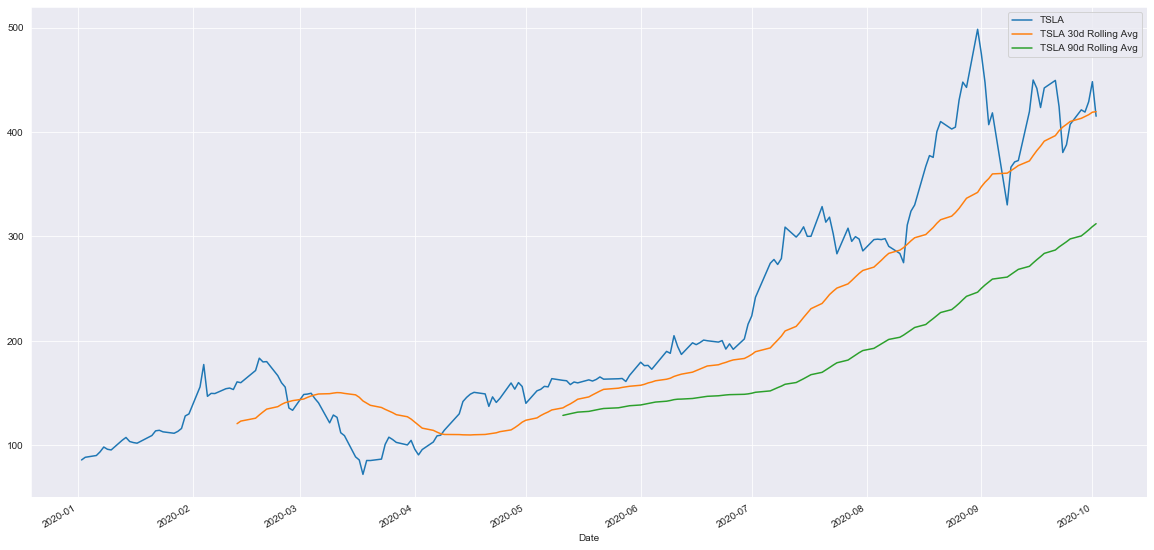

In [107]:
#plot of the moving averages and regular price
equity_data[['TSLA','TSLA 30d Rolling Avg','TSLA 90d Rolling Avg']].plot(grid = True, figsize = (20,10));

In [108]:
#calculating returns using math librbary. 

#Return
equity_data['Return'] = np.log(equity_data['TSLA']/equity_data['TSLA'].shift(1))

#Now lets calculate the 30d moving volatility of the share price
equity_data['Mov_Volatility'] = equity_data['Return'].rolling(window=30).std()* math.sqrt(30) #30d rolling avg

#Checking df
print(equity_data.tail())

                   GOOG        MSFT        TSLA  TSLA 30d Rolling Avg  \
Date                                                                    
2020-09-28  1464.520020  209.440002  421.200012                413.09   
2020-09-29  1469.329956  207.259995  419.070007                414.83   
2020-09-30  1469.599976  210.330002  429.010010                416.55   
2020-10-01  1490.089966  212.460007  448.160004                418.96   
2020-10-02  1458.420044  206.190002  415.089996                419.45   

            TSLA 90d Rolling Avg    Return  Mov_Volatility  
Date                                                        
2020-09-28                300.51  0.033460        0.405937  
2020-09-29                303.32 -0.005070        0.393178  
2020-09-30                306.28  0.023442        0.392943  
2020-10-01                309.44  0.043670        0.394778  
2020-10-02                312.23 -0.076655        0.398465  


In [109]:
equity_data['TSLA Return'] = np.log(equity_data['TSLA']/equity_data['TSLA'].shift(1))
equity_data['MSFT Return'] = np.log(equity_data['MSFT']/equity_data['MSFT'].shift(1))
#sns.pairplot(equity_data) #Works but not well.

## Building Pairs Model.

In [110]:
#assumptions:
#    For simplification purpose, we ignore bid-ask spreads.
#    We ignore transaction costs. 
#    Stationarity is present in random walk market in particular with in related pairs. 

In [111]:
equity_ticker = ['TSLA','MSFT', 'GOOG','IBM', 'VT', 'PEP', 'KO', 'XOM', 'SPY', 'NS','EPD', 'QQQ', 'JNJ']
today = date.today() 

df = yf.download(equity_ticker, 
                 start='2020-1-1', #selecting the starting date
                 end = today) #charting up to today's date
                 
data = df['Close']    
data.head(5)
#This got the Yahoo data to work for multipule stocks. 

[*********************100%***********************]  13 of 13 completed


,EPD,GOOG,IBM,JNJ,KO,MSFT,NS,PEP,QQQ,SPY,TSLA,VT,XOM
Date,,,,,,,,,,,,,
2020-01-02,28.129999,1367.369995,135.419998,145.970001,54.990002,160.619995,26.549999,135.820007,216.160004,324.869995,86.052002,81.809998,70.900002
2020-01-03,28.400000,1360.660034,134.339996,144.279999,54.689999,158.619995,26.629999,135.630005,214.179993,322.410004,88.601997,81.070000,70.330002
2020-01-06,28.700001,1394.209961,134.100006,144.100006,54.669998,159.029999,26.860001,136.149994,215.559998,323.640015,90.307999,81.370003,70.870003
2020-01-07,28.719999,1393.339966,134.190002,144.979996,54.250000,157.580002,27.059999,134.009995,215.529999,322.730011,93.811996,81.120003,70.290001
2020-01-08,28.639999,1404.319946,135.309998,144.960007,54.349998,160.089996,27.010000,134.699997,217.149994,324.450012,98.428001,81.449997,69.230003


In [112]:
#function to use coint command on all pairs in the selected protfolio.  
def find_coinintegrated_pairs(data):
    n = data.shape[1]
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            S1 = data[keys[i]]
            S2 = data[keys[j]]
            result = coint(S1, S2)
            score = result[0]
            pvalue = result[1]
            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue
            if pvalue < 0.01:
                pairs.append((keys[i], keys[j]))
    return score_matrix, pvalue_matrix, pairs


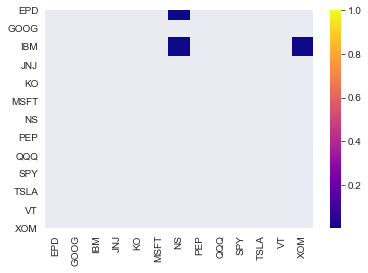

In [113]:
#applying the function above to the portfolio we have selected. 
scores, pvalues, pairs = find_coinintegrated_pairs(data)
sns.heatmap(pvalues, xticklabels = data.columns, yticklabels = data.columns,
            cmap = 'plasma', mask = (pvalues>= 0.01))

In [114]:
#From our heat map we observe that some pairs exist ('EPD','NS')and ('IBM', 'XOM') 
#seem to be significantly co-integrated with p-values of less than 0.01
#hence being highly statistically significant.

yf.pdr_override()
today = date.today()
stock1 = pdr.get_data_yahoo('EPD', start='2020-1-1', end = today)

stock2 = pdr.get_data_yahoo('XOM', start='2020-1-1', end = today)
riskfree = pdr.get_data_yahoo('ZROZ', start='2020-1-1', end = today)
SPY = pdr.get_data_yahoo('SPY', start='2020-1-1', end = today)#for return of market.

return_stock1 = stock1.Close.pct_change()[1:]
return_stock2 = stock2.Close.pct_change()[1:]
return_riskfree = riskfree.Close.pct_change()[1:]
return_SPY = SPY.Close.pct_change()[1:]

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


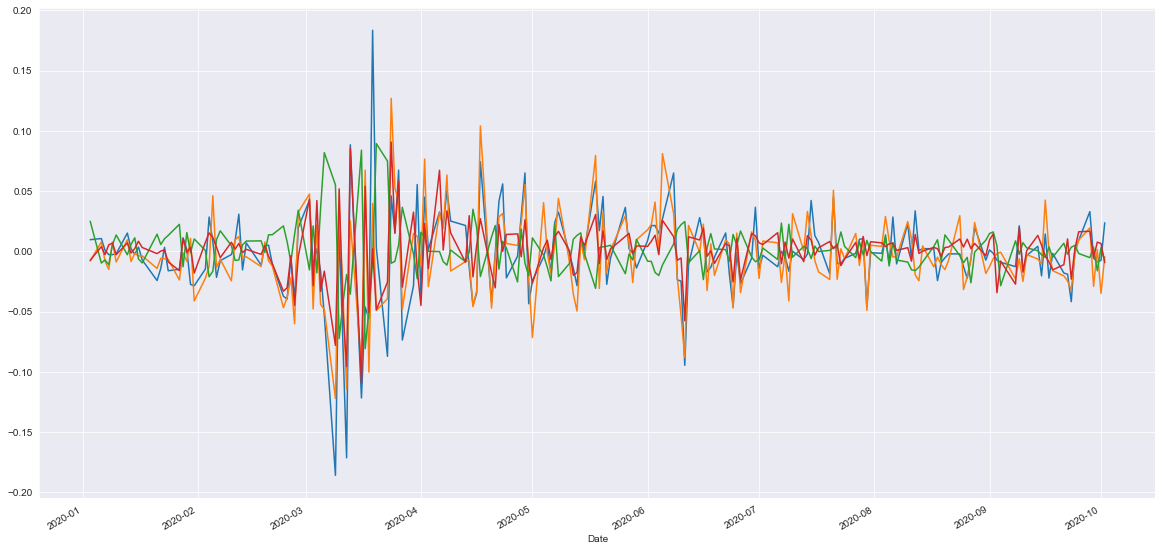

In [117]:
plt.figure(figsize=(20,10))
return_stock1.plot()
return_stock2.plot()
return_riskfree.plot()
return_SPY.plot()

In [116]:
coint_pairs = [('EPD','XOM'),('IBM', 'XOM'),('EPD','NS')]

for i in coint_pairs:
        S1 = data[i[0]]
        S2 = data[i[1]]
        score, pvalue, _= coint(S1,S2)
        print(pvalue)

0.19753837813337
0.008451512596725837
0.0035985254492143294


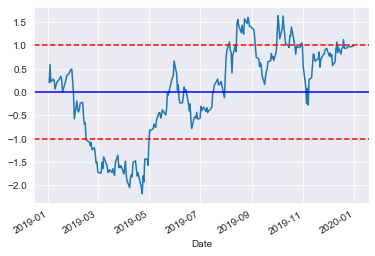

In [97]:
#Trading Strat
spread = data['EPD'] - data['XOM']

def zscore(stocks):
    return(stocks - stocks.mean())/np.std(stocks)

zscore(spread).plot()
plt.axhline(zscore(spread).mean(), c = 'b')
plt.axhline(1.0, c = 'red', ls = '--')
plt.axhline(-1.0, c = 'red', ls = '--')

## Pairs are stocks that trade similarily to one another (normally). 
## If the z-score > 1 -> short EPD and go long on XOM or long stock 1 above and short stock 2
## If the z-score > -1 -> short NS and go long on EPD. 
## If the z-score is approaching 0, we will close our short/long position

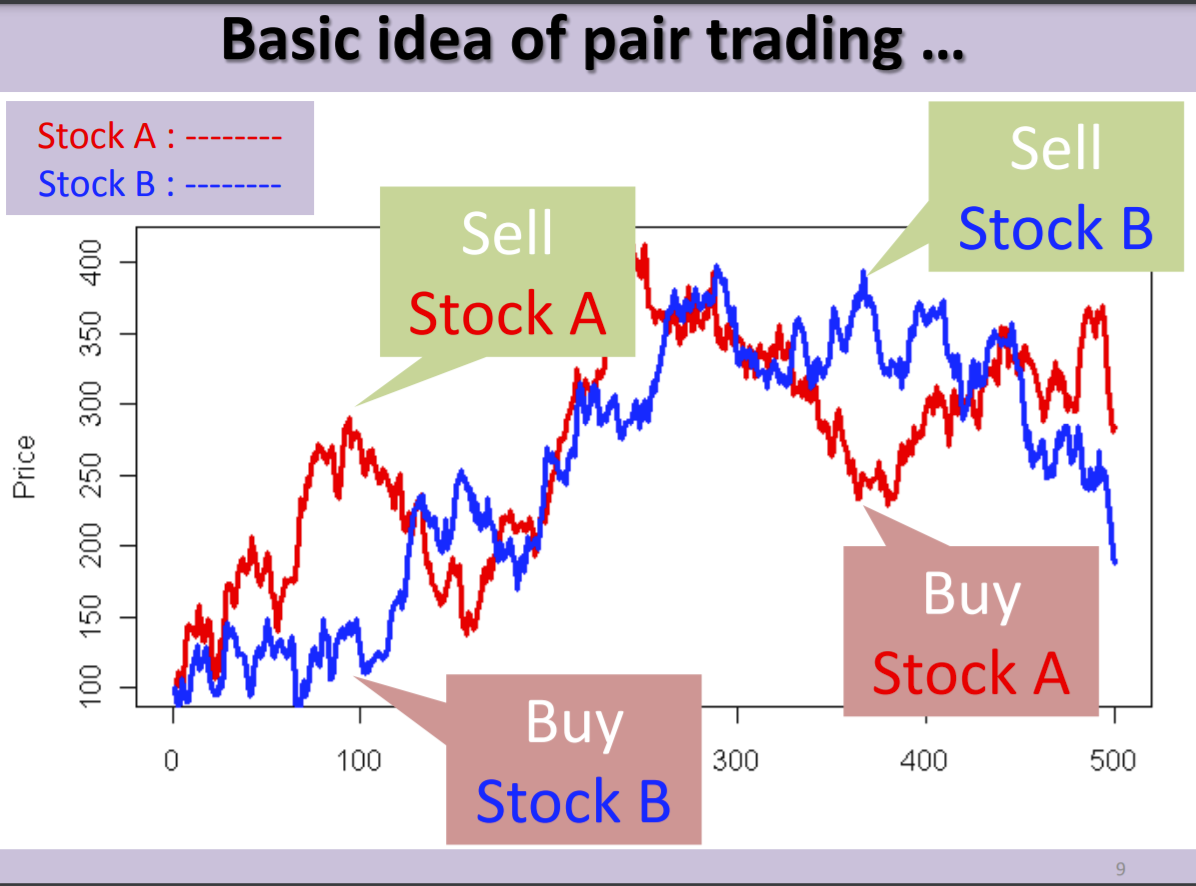

sourced from the r-forge library documentation

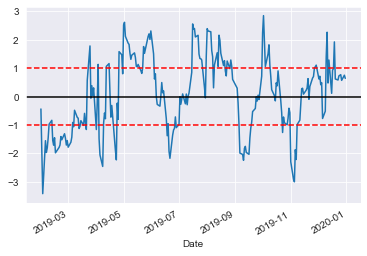

In [118]:
#this is based on the 20 day rolling avg. 
spread_mavg1 = spread.rolling(1).mean()
spread_mavg20 = spread.rolling(20).mean()
spread_std20 = spread.rolling(20).std()
zscore_20_1 = (spread_mavg1 - spread_mavg20)/spread_std20
zscore_20_1.plot(label = 'Rolling 20 day z score')
plt.axhline(0,color = 'black')
plt.axhline(1, c ='r',ls='--')
plt.axhline(-1, c ='r',ls='--')

## End of main code

In [85]:
# historical example
equity_ticker = ['TSLA','MSFT', 'GOOG','IBM', 'VT', 'PEP', 'KO', 'XOM', 'SPY', 'NS','EPD', 'QQQ', 'JNJ', 'BAC']
today = date.today() 

df = yf.download(equity_ticker, 
                 start='2019-1-1', #selecting the starting date
                 end = '2020-1-1') #charting up to today's date
                 
data = df['Close']    
data.head(5)

[*********************100%***********************]  14 of 14 completed


,BAC,EPD,GOOG,IBM,JNJ,KO,MSFT,NS,PEP,QQQ,SPY,TSLA,VT,XOM
Date,,,,,,,,,,,,,,
2019-01-02,24.959999,24.990000,1045.849976,115.209999,127.750000,46.930000,101.120003,21.290001,109.279999,154.880005,250.179993,62.023998,65.379997,69.690002
2019-01-03,24.559999,25.450001,1016.059998,112.910004,125.720001,46.639999,97.400002,21.459999,108.260002,149.820007,244.210007,60.071999,64.360001,68.620003
2019-01-04,25.580000,26.510000,1070.709961,117.320000,127.830002,47.570000,101.930000,22.750000,110.480003,156.229996,252.389999,63.537998,66.449997,71.150002
2019-01-07,25.559999,27.120001,1068.390015,118.150002,127.010002,46.950001,102.059998,23.180000,109.529999,158.089996,254.380005,66.991997,66.860001,71.519997
2019-01-08,25.510000,27.520000,1076.280029,119.830002,129.960007,47.480000,102.800003,24.459999,110.580002,159.520004,256.769989,67.070000,67.400002,72.040001


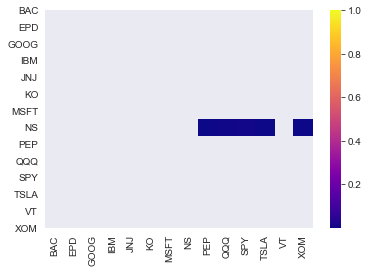

In [86]:
scores, pvalues, pairs = find_coinintegrated_pairs(data)
sns.heatmap(pvalues, xticklabels = data.columns, yticklabels = data.columns,
            cmap = 'plasma', mask = (pvalues>= 0.01))

In [90]:
coint_pairs = [('EPD','XOM')]

for i in coint_pairs:
        S1 = data[i[0]]
        S2 = data[i[1]]
        score, pvalue, _= coint(S1,S2)
        print(pvalue)
        
#Short EPD long XOM

0.4914877545176984


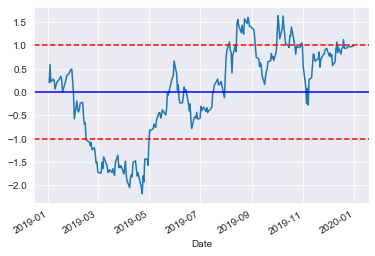

In [87]:
#Trading Strat
spread = data['EPD'] - data['XOM']

def zscore(stocks):
    return(stocks - stocks.mean())/np.std(stocks)

zscore(spread).plot()
plt.axhline(zscore(spread).mean(), c = 'b')
plt.axhline(1.0, c = 'red', ls = '--')
plt.axhline(-1.0, c = 'red', ls = '--')

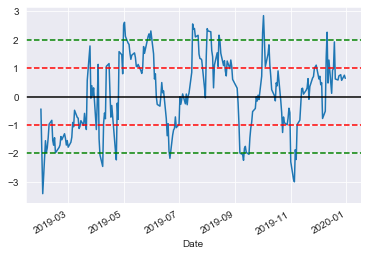

In [89]:
#this is based on the 20 day rolling avg. 
spread_mavg1 = spread.rolling(1).mean()
spread_mavg20 = spread.rolling(20).mean()
spread_std20 = spread.rolling(20).std()
zscore_20_1 = (spread_mavg1 - spread_mavg20)/spread_std20
zscore_20_1.plot(label = 'Rolling 20 day z score')
plt.axhline(0,color = 'black')
plt.axhline(1, c ='r',ls='--')
plt.axhline(-1, c ='r',ls='--')
plt.axhline(2, c ='g',ls='--')
plt.axhline(-2, c ='g',ls='--')

In [95]:
print(data['EPD']['2019-10-01']) #SHORT

print(data['XOM']['2019-10-01']) #LONG

28.520000457763672
68.94999694824219


In [96]:
print(data['EPD']['2019-11-01']) #SHORT

print(data['XOM']['2019-11-01']) #LONG

26.25
69.5999984741211


## Draft code below

In [40]:
YTD_return_stock1=sum(return_stock1) / len(return_stock1)
YTD_return_stock2=sum(return_stock2) / len(return_stock2)
YTD_return_SPY=sum(return_SPY) / len(return_SPY)
YTD_return_riskfree=sum(return_riskfree) / len(return_riskfree)

print(YTD_return_stock1,YTD_return_stock2, YTD_return_SPY,YTD_return_riskfree)
#print(sum(return_stock1)) down 46% this year, maybe not the best example. 

-0.002262113244970567 -0.002518094455765615 0.000424412623913291 0.0014039189394851766


In [13]:
def CAPM(stock, market, riskfree):
    return(stock - riskfree)/(market - riskfree)

beta1 = CAPM(YTD_return_stock1,YTD_return_SPY, YTD_return_riskfree)
print(beta1)

3.424352827538739


Pssible next steps:
1.) Check model on historical data using beta weights for risk nuteral play.
2.) Compare cointergration method with newer distance method that apparently performs better. 

In [ ]:
#
#
#
#
# Below is rought work.

In [19]:
#this uses the yahoo package and outputs more detail. 

tickerSymbol = 'TSLA'#Cannot take lists like above. 
today = date.today()

#get data on this ticker
tickerData = yf.Ticker(tickerSymbol)

#get the historical prices for this ticker
tickerDf = tickerData.history(period='1d', start='2020-1-1', end=today)
tickerDf.head(8)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2020-01-02,84.90,86.14,84.34,86.05,47660500,0,0.0
2020-01-03,88.10,90.80,87.38,88.60,88892500,0,0.0
2020-01-06,88.09,90.31,88.00,90.31,50665000,0,0.0
2020-01-07,92.28,94.33,90.67,93.81,89410500,0,0.0
2020-01-08,94.74,99.70,93.65,98.43,155721500,0,0.0
2020-01-09,99.42,99.76,94.57,96.27,142202000,0,0.0
2020-01-10,96.36,96.99,94.74,95.63,64797500,0,0.0
2020-01-13,98.70,105.13,98.40,104.97,132588000,0,0.0


In [ ]:
#define the ticker symbol
tickerSymbol = 'MSFT'

#get data on this ticker
tickerData = yf.Ticker(tickerSymbol)

#get recommendation data for ticker
tickerData.recommendations